In [1]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import spacy
from IPython.display import clear_output
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid',palette='rainbow')
from wordcloud import WordCloud
import os

# Using rapid api get the review

<a href="https://www.amazon.in/Data-Science-Transform-Visualize-Model/dp/9352134974/ref=sr_1_11?keywords=data+science+book&sr=8-11"> The Product I am Reviewing is : R for Data Science: Import, Tidy, Transform, Visualize, and Model Data (Greyscale Indian Edition) <a/>

**The Below code is used to make api calls which then responds with review data. This code might result in null reviews dictionary cuz the version i am using is free tier and only allows 50 api calls / month and i might have used up all of my calls**

**The Api i am using is <a href="https://rapidapi.com/letscrape-6bRBa3QguO5/api/real-time-amazon-data/">Amazon review</a> if you get the above mentioned error just head to this page and subscribe to this api it free. Then you just need to change the headers variable. You can find headers in api playground section**

In [2]:
reviews = {
    'Title':[],
    'Review':[]
}
for i in tqdm(range(20)):
    url = "https://real-time-amazon-data.p.rapidapi.com/product-reviews"
    querystring = {"asin":"9352134974","country":"IN","verified_purchases_only":"false",
                   "images_or_videos_only":"false","page":f"{i+1}","page_size":"10"}
    display(querystring)
    headers = os.environ["RAPIDAPI_KEY"]
    response = requests.get(url, headers=headers, params=querystring)
    try:
        rvs = response.json()['data']['reviews']
        if len(rvs) != 0:
            for rv in rvs:
                reviews['Title'].append(rv['review_title'])
                reviews['Review'].append(rv['review_comment'])
        else:
            clear_output(wait=True)
            break
    except Exception as e:
        clear_output(wait=True)
        pass
    clear_output(wait=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]


In [3]:
df = pd.DataFrame(reviews)
df

,Title,Review
0,"Fine book, Worth the money!",Helpful for the beginners who are starting dat...
1,Black and white only,Book cover and paper quality is okay. Package ...
2,If R is Ferrari of Data science world then thi...,Firstly understand that this book does not cov...
3,Highly recommended,The author has taken a good approach. Instead...
4,Suitable for Data analyst,Go for it. learn it
...,...,...
165,Perfetto,Fornisce un ottima guida per quello che riguar...
166,Best book to learn how to handle data in R,Really enjoyed this book. Full of examples. I...
167,Very easy to follow.,Is to follow. Very well written.
168,Covers basics very well,Easy step by step coding for data science...re...


**If above doesnot work i already saved the reviews in csv form so load it**

In [4]:
# Run only if above code doesnot work
# df = pd.read_csv('./Product_review.csv',index_col=0)
# df

In [5]:
df.isna().any()

Title     False
Review    False
dtype: bool

In [6]:
df.dropna(axis=0,inplace=True)

# Cleaning

In [7]:
def clean_twitter_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove hashtags (#hashtag)
    text = re.sub(r"#([^\s]+)", r"\1", text)
    
    # Remove characters inside brackets (<text>, {text}, [text], (text))
    text = re.sub(r"<[^>]+>|\{[^}]+\}|\[[^\]]+\]|\([^)]+\)", "", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s'.]", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text.lower()

In [8]:
stop_word = []
with open('./stop.txt','r') as file:
    content = file.readlines()
    for line in content:
        stop_word.append(line.lower())
stop_word = [x.replace('\n','') for x in stop_word]

In [9]:
positive_word = []
with open('./positive-words.txt','r') as file:
    content = file.readlines()
    for line in content:
        positive_word.append(line.lower())
positive_word = [x.replace('\n','') for x in positive_word]

In [10]:
negative_word = []
with open('./negative-words.txt','r') as file:
    content = file.readlines()
    for line in content:
        negative_word.append(line.lower())
negative_word = [x.replace('\n','') for x in negative_word]

In [11]:
def remove_stop_word(text,stop_word):
    text = clean_twitter_text(text)
    ftext = []
    words = text.split(' ')
    for word in words:
        if (word not in stop_word) and (word != '.'):
            word = word.replace('.','')
            ftext.append(word)
    return ' '.join(ftext)
    

In [12]:
df['Clean Title'] = df['Title'].apply(lambda x : remove_stop_word(x,stop_word))
df['Clean Review'] = df['Review'].apply(lambda x : remove_stop_word(x,stop_word))
df

,Title,Review,Clean Title,Clean Review
0,"Fine book, Worth the money!",Helpful for the beginners who are starting dat...,fine book worth money,helpful beginners starting data visualization ...
1,Black and white only,Book cover and paper quality is okay. Package ...,black white,book cover paper quality okay package good buy...
2,If R is Ferrari of Data science world then thi...,Firstly understand that this book does not cov...,ferrari data science world book nut bolt manua...,firstly understand book cover models algorithm...
3,Highly recommended,The author has taken a good approach. Instead...,highly recommended,author good approach giving introduction theor...
4,Suitable for Data analyst,Go for it. learn it,suitable data analyst,it learn
...,...,...,...,...
165,Perfetto,Fornisce un ottima guida per quello che riguar...,perfetto,fornisce ottima guida quello che riguarda data...
166,Best book to learn how to handle data in R,Really enjoyed this book. Full of examples. I...,book learn handle data,enjoyed book full examples learning bookhigh q...
167,Very easy to follow.,Is to follow. Very well written.,easy follow,follow written
168,Covers basics very well,Easy step by step coding for data science...re...,covers basics,easy step step coding data sciencereally recom...


# Sentiment Analysis

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
# positive words
def count_from_dict(x,dicts):
    count = 0
    sen = nlp(x)
    for i in sen:
        if i.lemma_ in dicts:
            count += 1
    return count

In [15]:
pos = []
for row,col in df.iterrows():
    display(row)
    count = 0 
    count += count_from_dict(col['Clean Title'],positive_word)
    count += count_from_dict(col['Clean Review'],positive_word)
    pos.append(count)
    clear_output(wait=True)

169

In [16]:
df['Positive Score'] = pos
df

,Title,Review,Clean Title,Clean Review,Positive Score
0,"Fine book, Worth the money!",Helpful for the beginners who are starting dat...,fine book worth money,helpful beginners starting data visualization ...,8
1,Black and white only,Book cover and paper quality is okay. Package ...,black white,book cover paper quality okay package good buy...,1
2,If R is Ferrari of Data science world then thi...,Firstly understand that this book does not cov...,ferrari data science world book nut bolt manua...,firstly understand book cover models algorithm...,11
3,Highly recommended,The author has taken a good approach. Instead...,highly recommended,author good approach giving introduction theor...,4
4,Suitable for Data analyst,Go for it. learn it,suitable data analyst,it learn,1
...,...,...,...,...,...
165,Perfetto,Fornisce un ottima guida per quello che riguar...,perfetto,fornisce ottima guida quello che riguarda data...,1
166,Best book to learn how to handle data in R,Really enjoyed this book. Full of examples. I...,book learn handle data,enjoyed book full examples learning bookhigh q...,1
167,Very easy to follow.,Is to follow. Very well written.,easy follow,follow written,1
168,Covers basics very well,Easy step by step coding for data science...re...,covers basics,easy step step coding data sciencereally recom...,2


In [17]:
neg = []
for row,col in df.iterrows():
    display(row)
    count = 0 
    count += count_from_dict(col['Clean Title'],negative_word)
    count += count_from_dict(col['Clean Review'],negative_word)
    neg.append(count)
    clear_output(wait=True)

169

In [18]:
df['Negative Score'] = neg
df

,Title,Review,Clean Title,Clean Review,Positive Score,Negative Score
0,"Fine book, Worth the money!",Helpful for the beginners who are starting dat...,fine book worth money,helpful beginners starting data visualization ...,8,0
1,Black and white only,Book cover and paper quality is okay. Package ...,black white,book cover paper quality okay package good buy...,1,0
2,If R is Ferrari of Data science world then thi...,Firstly understand that this book does not cov...,ferrari data science world book nut bolt manua...,firstly understand book cover models algorithm...,11,8
3,Highly recommended,The author has taken a good approach. Instead...,highly recommended,author good approach giving introduction theor...,4,1
4,Suitable for Data analyst,Go for it. learn it,suitable data analyst,it learn,1,0
...,...,...,...,...,...,...
165,Perfetto,Fornisce un ottima guida per quello che riguar...,perfetto,fornisce ottima guida quello che riguarda data...,1,0
166,Best book to learn how to handle data in R,Really enjoyed this book. Full of examples. I...,book learn handle data,enjoyed book full examples learning bookhigh q...,1,0
167,Very easy to follow.,Is to follow. Very well written.,easy follow,follow written,1,0
168,Covers basics very well,Easy step by step coding for data science...re...,covers basics,easy step step coding data sciencereally recom...,2,0


In [19]:
sia = SentimentIntensityAnalyzer()

In [20]:
def get_polarity(text):
    text = clean_twitter_text(text)
    return sia.polarity_scores(text)['compound']

In [21]:
pol = []
for row , col in df.iterrows():
    display(row)
    text = col['Clean Title'] + ' ' + col['Clean Review']
    pol.append(get_polarity(text))
    clear_output(wait=True)

169

In [22]:
df['Polarity Score'] = pol
df

,Title,Review,Clean Title,Clean Review,Positive Score,Negative Score,Polarity Score
0,"Fine book, Worth the money!",Helpful for the beginners who are starting dat...,fine book worth money,helpful beginners starting data visualization ...,8,0,0.9022
1,Black and white only,Book cover and paper quality is okay. Package ...,black white,book cover paper quality okay package good buy...,1,0,0.5859
2,If R is Ferrari of Data science world then thi...,Firstly understand that this book does not cov...,ferrari data science world book nut bolt manua...,firstly understand book cover models algorithm...,11,8,0.9607
3,Highly recommended,The author has taken a good approach. Instead...,highly recommended,author good approach giving introduction theor...,4,1,0.9182
4,Suitable for Data analyst,Go for it. learn it,suitable data analyst,it learn,1,0,0.0000
...,...,...,...,...,...,...,...
165,Perfetto,Fornisce un ottima guida per quello che riguar...,perfetto,fornisce ottima guida quello che riguarda data...,1,0,0.0000
166,Best book to learn how to handle data in R,Really enjoyed this book. Full of examples. I...,book learn handle data,enjoyed book full examples learning bookhigh q...,1,0,0.5106
167,Very easy to follow.,Is to follow. Very well written.,easy follow,follow written,1,0,0.4404
168,Covers basics very well,Easy step by step coding for data science...re...,covers basics,easy step step coding data sciencereally recom...,2,0,0.6597


In [23]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [24]:
df['Sentiment'] = df['Polarity Score'].apply(get_sentiment)
df

,Title,Review,Clean Title,Clean Review,Positive Score,Negative Score,Polarity Score,Sentiment
0,"Fine book, Worth the money!",Helpful for the beginners who are starting dat...,fine book worth money,helpful beginners starting data visualization ...,8,0,0.9022,Positive
1,Black and white only,Book cover and paper quality is okay. Package ...,black white,book cover paper quality okay package good buy...,1,0,0.5859,Positive
2,If R is Ferrari of Data science world then thi...,Firstly understand that this book does not cov...,ferrari data science world book nut bolt manua...,firstly understand book cover models algorithm...,11,8,0.9607,Positive
3,Highly recommended,The author has taken a good approach. Instead...,highly recommended,author good approach giving introduction theor...,4,1,0.9182,Positive
4,Suitable for Data analyst,Go for it. learn it,suitable data analyst,it learn,1,0,0.0000,Neutral
...,...,...,...,...,...,...,...,...
165,Perfetto,Fornisce un ottima guida per quello che riguar...,perfetto,fornisce ottima guida quello che riguarda data...,1,0,0.0000,Neutral
166,Best book to learn how to handle data in R,Really enjoyed this book. Full of examples. I...,book learn handle data,enjoyed book full examples learning bookhigh q...,1,0,0.5106,Positive
167,Very easy to follow.,Is to follow. Very well written.,easy follow,follow written,1,0,0.4404,Positive
168,Covers basics very well,Easy step by step coding for data science...re...,covers basics,easy step step coding data sciencereally recom...,2,0,0.6597,Positive


# Viz

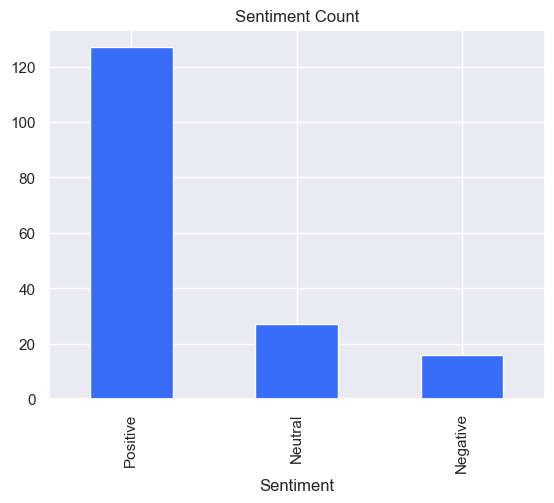

In [25]:
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Count')
plt.show()

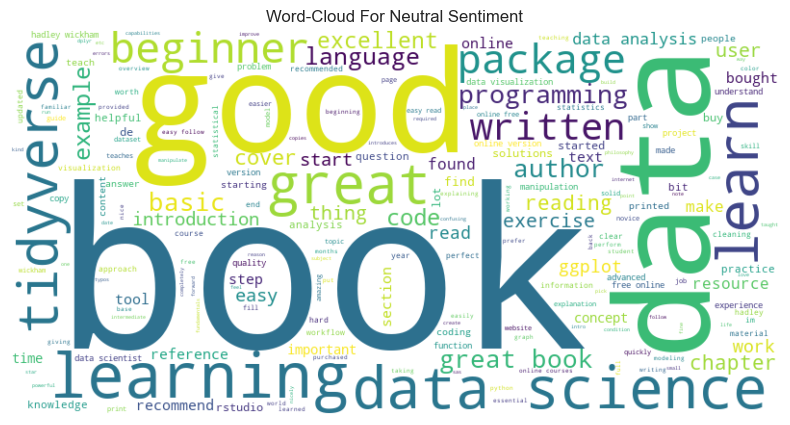

In [26]:
words = " ".join(df[df['Sentiment']=='Positive']['Clean Title'])
words += " ".join(df[df['Sentiment']=='Positive']['Clean Review'])
wc = WordCloud(width=800, height=400, background_color='white').generate(words)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word-Cloud For Neutral Sentiment')
plt.show()

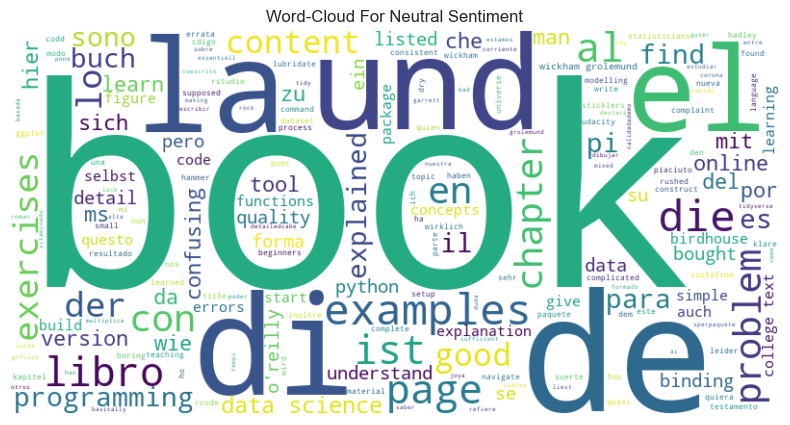

In [27]:
words = " ".join(df[df['Sentiment']=='Negative']['Clean Title'])
words += " ".join(df[df['Sentiment']=='Negative']['Clean Review'])
wc = WordCloud(width=800, height=400, background_color='white').generate(words)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word-Cloud For Neutral Sentiment')
plt.show()